# Supercritical CO2 Property Surrogate with ALAMO Surrogate Object - Training Surrogate (Part -1)

## 1. Introduction
This notebook demonstrates leveraging of the ALAMO surrogate trainer and IDAES Python wrapper to produce an surrogate based on supercritical CO2 data from simulation using REFPROP package.

There are several reasons to build surrogate models for complex processes, even when higher fidelity models already exist (e.g., reduce model size, improve convergence reliability, replace models with externally compiled code and make them fully-equation oriented).

In this example, we intend to make a surrogate for the physical properties of S-CO2 to be embedded in the property package. This property package will be used to get the physical properties of S-CO2 in the flowsheet simulation. To learn more about property package, see the [IDAES-PSE](https://github.com/IDAES/idaes-pse) Github Page or IDAES [Read-the-docs](https://idaes-pse.readthedocs.io/en/latest/). 

### 1.1 Need for ML Surrogate

The properties predicted by the surrogate are enthalpy and entropy of the S-CO2 based on the 
pressure and temperature of the system. The analytical equation of getting the enthalpy and entropy from pressure and temperature are in the differential form and would make the problem a DAE system. To counter this problem and keep the problem algebric, we will use the surrogates and relate enthalpy and entropy with the pressure and temperature as an algebric equation.

### 1.2 Supercritical CO2 cycle process

The following flowsheet will be used to optimize the design for the cooling of the fusion reactor using supercritical CO2 cycle. We shall focus on training the surrogate for this notebook and move to constructing the flowsheet and the properties package in the subsequent notebooks. The take away from this flowsheet is that, 3 variables can be measured in any given unit which are flow, pressure and temperature and other properties can be calculated using them. Thus, surrogate should have pressure and temperature as the inputs.

In this example, we will train a model using AlamoTrainer for our data and then demonstrate that we can solve an optimization problem with that surrogate model. 

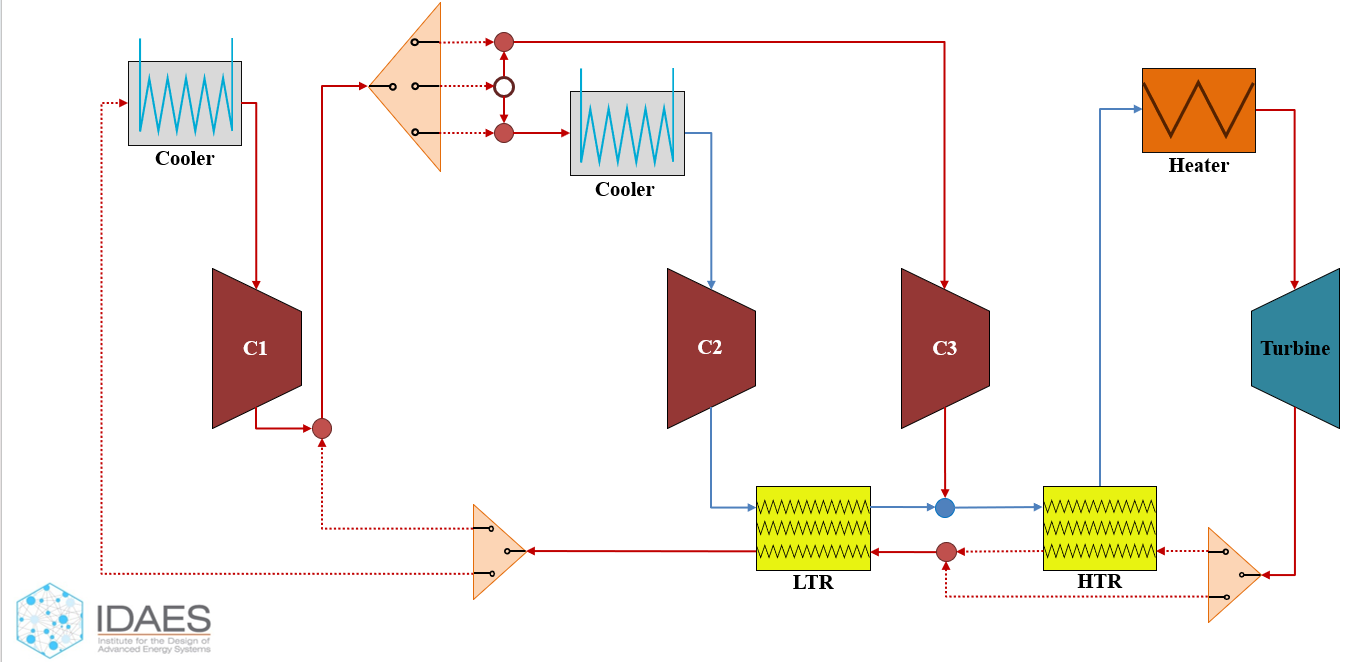

In [1]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("CO2_Flowsheet.png"))

## 2. Training and Validating Surrogate

First, let's import the required Python and IDAES modules:

In [2]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.alamopy import AlamoTrainer, AlamoSurrogate, alamo
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)

### 2.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 500 data points were simulated for S-CO2 physical properties using REFPROP package. This example is trained on the entire dataset to have cover different ranges of pressure and temperature. The data is separated using an 80/20 split into training and validation data using the IDAES split_training_validation() method.

We rename the column headers because they contained ".", we change "." to "_" as ALAMO accepts alphanumerical characters or underscores as the labels for input/output. Further, the input variables are **pressure**, **temperature** , while the output variables are **enth_mol**, **entr_mol**, hence we create two new dataframes for the input and output variables.

In [3]:
# Import training data
np.set_printoptions(precision=7, suppress=True)

csv_data = pd.read_csv(datafile_path('500_Points_DataSet.csv'))  

### ALAMO only accepts alphanumerical characters (A-Z, a-z, 0-9) or underscores as input/output labels
cols=csv_data.columns
cols=[item.replace(".", "_") for item in cols]
csv_data.columns=cols

data = csv_data.sample(n=500,random_state=0) 

input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:4]

# Define labels, and split training and validation data
input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
) 

### 2.2 Training Surrogate with ALAMO

IDAES provides a Python wrapper for the ALAMO machine learning tool via an imported AlamoTrainer class. Regression settings can be directly set as config attributes, as shown below. In this example, allowed basis terms include constant and linear functions, monomial power order 2 and 3, variable product power order 1 and 2, and variable ratio power order 1 and 2. ALAMO seeks to minimize the number of basis terms; here, we restrict each surrogate expression to a maximum of 10 basis terms.

Finally, after training the model we save the results and model expressions to a JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [4]:
# Create ALAMO trainer object
has_alamo=alamo.available()
if has_alamo:
    trainer = AlamoTrainer(
        input_labels=input_labels,
        output_labels=output_labels,
        training_dataframe=data_training,
    )

    # Set ALAMO options
    trainer.config.constant = True
    trainer.config.linfcns = True
    trainer.config.multi2power = [1, 2]
    trainer.config.monomialpower = [2, 3]
    trainer.config.ratiopower = [1]
    trainer.config.maxterms = [10] * len(output_labels)  # max terms for each surrogate
    trainer.config.filename = os.path.join(os.getcwd(), "alamo_run.alm")
    trainer.config.overwrite_files = True

    # Train surrogate (calls ALAMO through IDAES ALAMOPy wrapper)
    success, alm_surr, msg = trainer.train_surrogate()

    # save model to JSON
    model = alm_surr.save_to_file("alamo_surrogate.json", overwrite=True)

    # create callable surrogate object
    surrogate_expressions = trainer._results["Model"]
    input_labels = trainer._input_labels
    output_labels = trainer._output_labels
    xmin, xmax = [7,306], [40,1000]
    input_bounds = {
        input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))
    }

    alm_surr = AlamoSurrogate(
        surrogate_expressions, input_labels, output_labels, input_bounds
    )
else:
    print('Alamo not found.')

 ***************************************************************************
 ALAMO version 2023.2.13. Built: WIN-64 Mon Feb 13 21:30:56 EST 2023

 If you use this software, please cite:
 Cozad, A., N. V. Sahinidis and D. C. Miller,
 Automatic Learning of Algebraic Models for Optimization,
 AIChE Journal, 60, 2211-2227, 2014.

 ALAMO is powered by the BARON software from http://www.minlp.com/
 ***************************************************************************
 Licensee: Javal Vyas at Carnegie Mellon University, jvyas@andrew.cmu.edu.
 ***************************************************************************
 Reading input data
 Checking input consistency and initializing data structures
 
 Step 0: Initializing data set
 User provided an initial data set of 400 data points
 We will sample no more data points at this stage
 ***************************************************************************
 Iteration 1 (Approx. elapsed time 0.62E-01 s)
 
 Step 1: Model building using B

### 2.3 Visualizing Surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

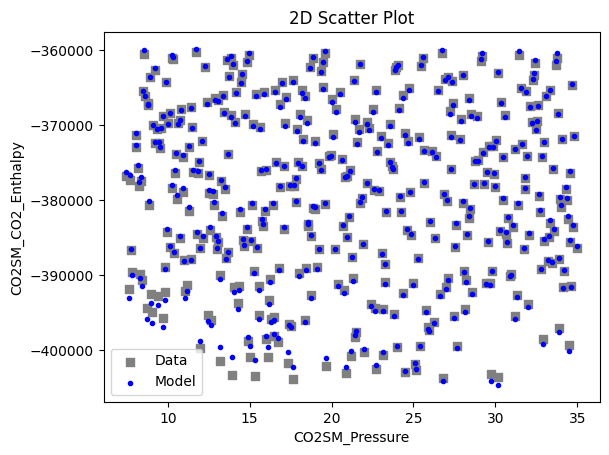

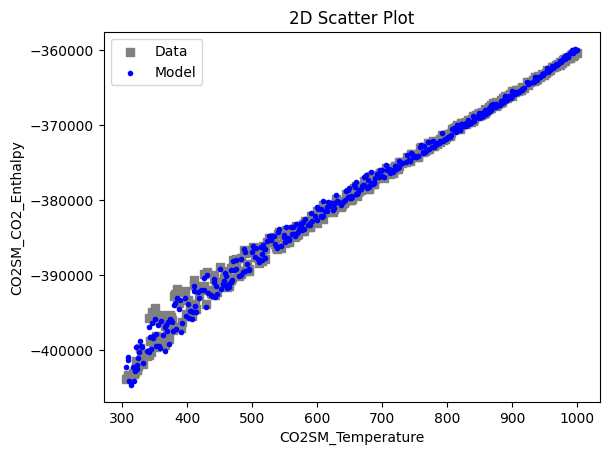

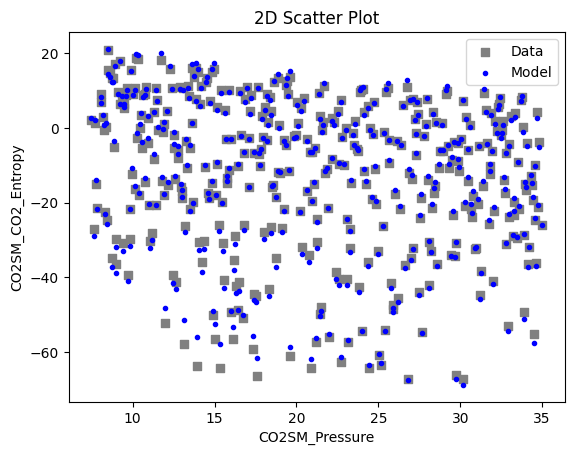

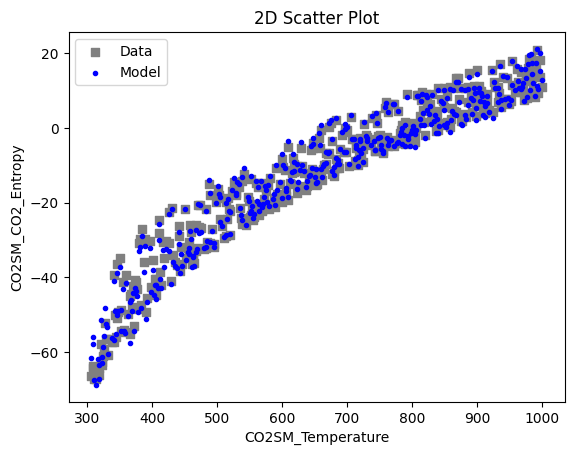

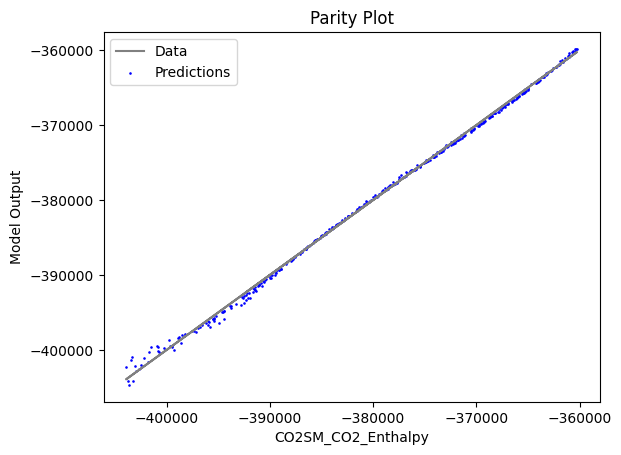

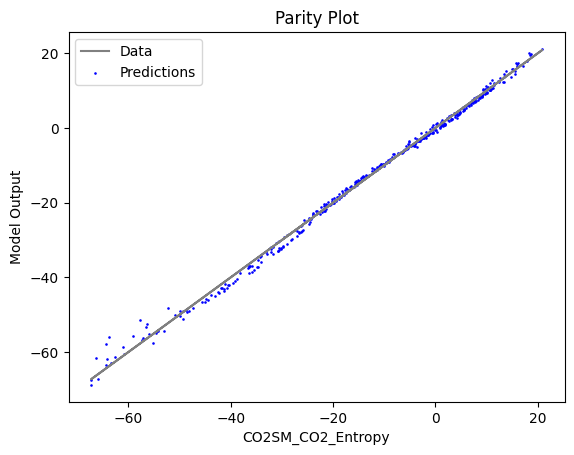

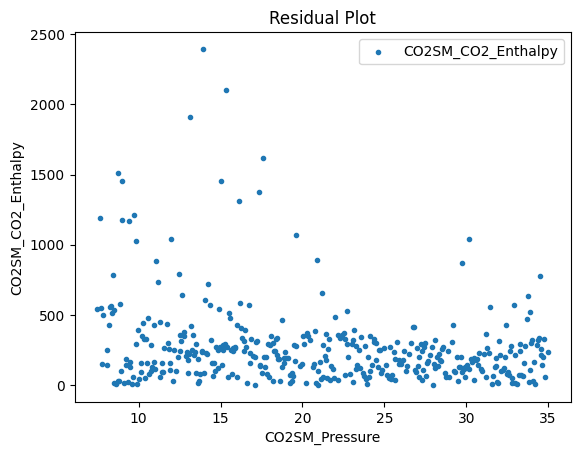

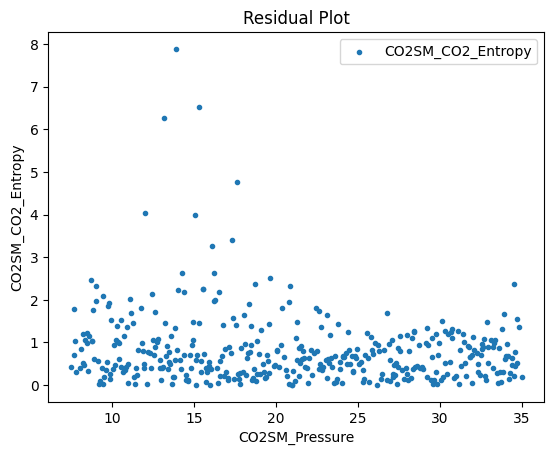

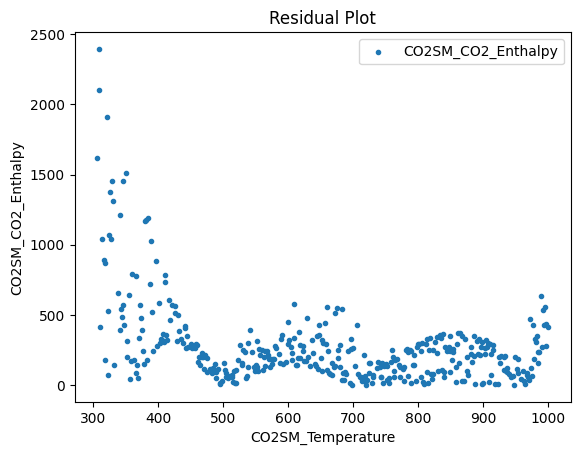

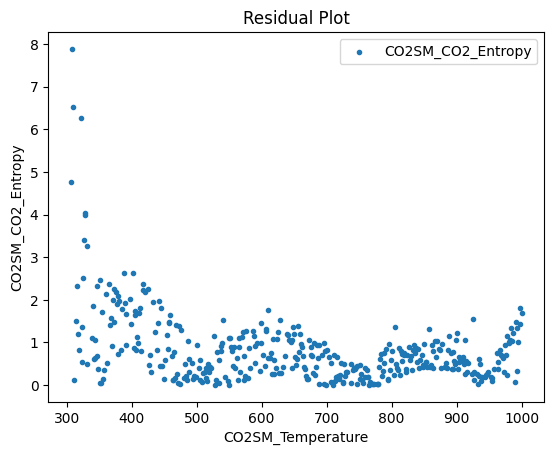

In [5]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(alm_surr, data_training)
surrogate_parity(alm_surr, data_training)
surrogate_residual(alm_surr, data_training)

### 2.4 Model Validation

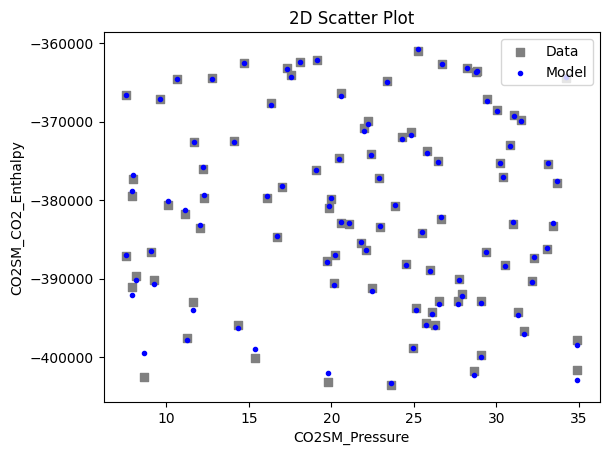

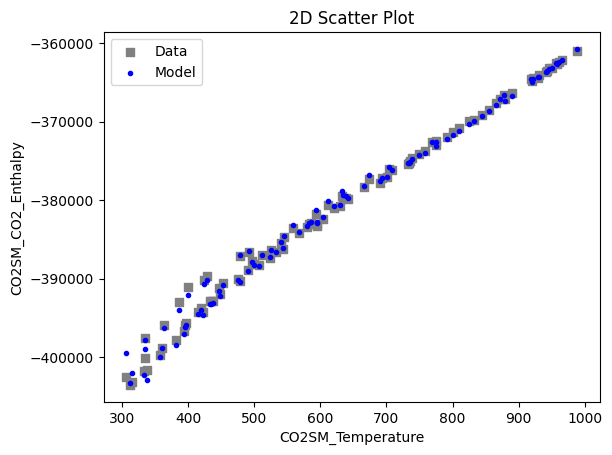

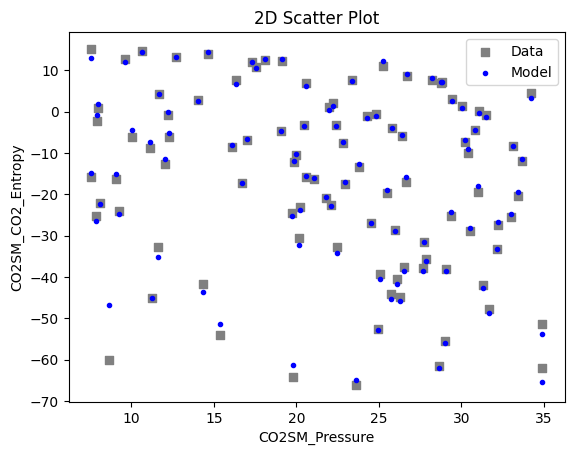

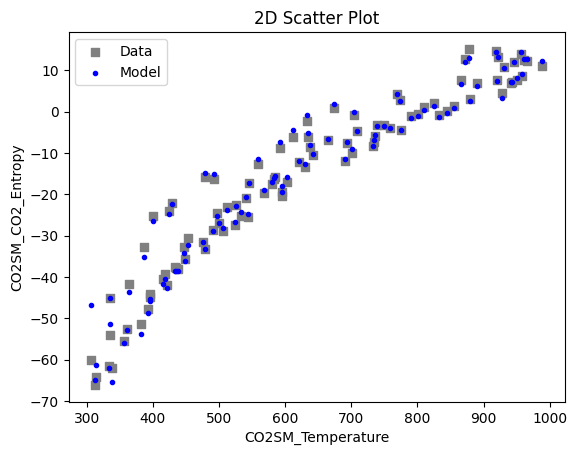

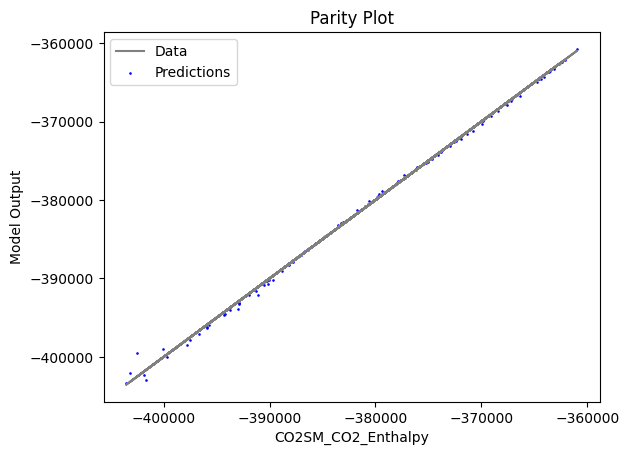

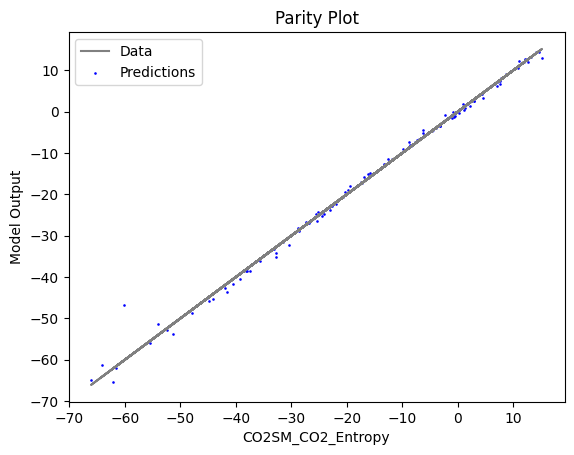

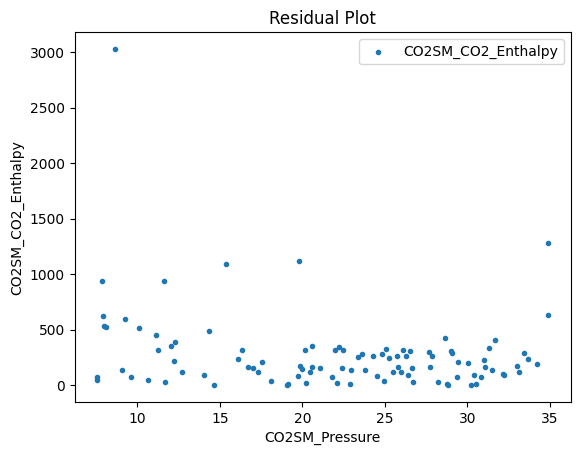

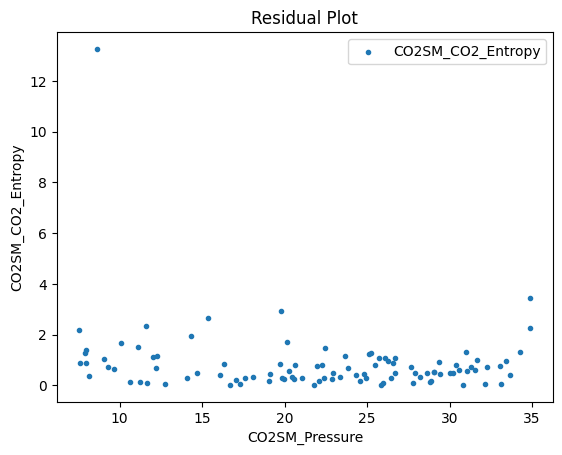

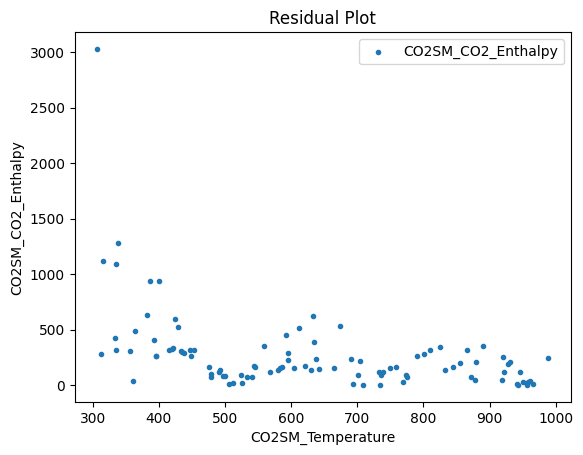

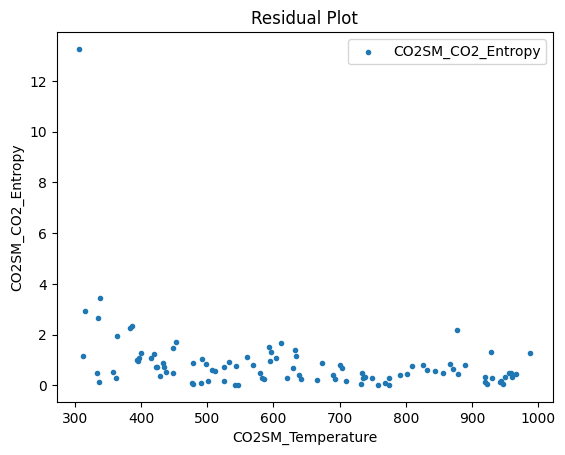

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(alm_surr, data_validation)
surrogate_parity(alm_surr, data_validation)
surrogate_residual(alm_surr, data_validation)

Now, the surrogate is trained and validated, we shall embed it in the property package, which is demonstrated in the [SCO2_properties_alamo_surrogate_embedding](https://github.com/IDAES/examples/blob/supercritcial_CO2_example/idaes_examples/notebooks/docs/surrogates/SCO2_example/ALAMO/SCO2_properties_alamo_surrogate_embedding_usr.ipynb) file.